#### Date: Jun 2019<br>Programmer: Christian Dittmar, Yiğitcan Özer
This is the demo script which illustrates the main functionalities of the 'NMF toolbox'. For a detailed description we refer to [1,2] (see References below).

#### The script proceeds in the following steps:
<br>1. It loads an target audio file containing the intro of the song "Let it be", by "The Beatles".
<br>2. It loads a source audio file containing the sound of buzzing bees in different pitches.
<br>3. It computes the STFT of all audio data.
<br>4. It applies the diagonal NMF as described in [1], in order to approximate the target with the timbral content of the source.
<br>5. It visualizes the NMF results.
<br>6. It resynthesizes the audio mosaic.

#### References
[1] Jonathan Driedger, Thomas Prätzlich, and Meinard Müller<br>
Let It Bee — Towards NMF-Inspired Audio Mosaicing<br>
In Proceedings of the International Conference on Music Information Retrieval (ISMIR): 350–356, 2015.

#### If you use the 'NMF toolbox' please refer to 
[2] Patricio López-Serrano, Christian Dittmar, Yiğitcan Özer, and Meinard Müller<br>NMF Toolbox: Music Processing Applications of Nonnegative Matrix Factorization<br>In Proceedings of the International Conference on Digital Audio Effects (DAFx), 2019.

#### License:
This file is part of 'NMF toolbox'. 'NMF toolbox' is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. 'NMF toolbox' is distributed in the hope that it will be useful, but ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General Public License for more details.

#### You should have received a copy of the GNU General Public License along<br>with 'NMF toolbox'. If not, see http://www.gnu.org/licenses/.

### Initialization

In [1]:
import os
import numpy as np
import scipy.io.wavfile as wav
import IPython.display as ipd

from NMFtoolbox.utils import EPS, MAX_WAV_VALUE, make_monaural, pcmInt16ToFloat32Numpy
from NMFtoolbox.forwardSTFT import forwardSTFT
from NMFtoolbox.NMFdiag import NMFdiag
from NMFtoolbox.visualizeComponentsNMF import visualizeComponentsNMF
from NMFtoolbox.LSEE_MSTFTM_GriffinLim import LSEE_MSTFTM_GriffinLim

inpPath = '../data/'
outPath = 'output/'

# create the output directory if it doesn't exist
if not os.path.isdir(outPath):
    os.makedirs(outPath)

filenameSource = 'Bees_Buzzing.wav'
filenameTarget = 'Beatles_LetItBe.wav'

### 1. Load the source and target signal

In [2]:
# read signals
fs, xs = wav.read(os.path.join(inpPath, filenameSource))
fs, xt = wav.read(os.path.join(inpPath, filenameTarget))

# make monaural if necessary
make_monaural(xs)
make_monaural(xt)

# convert wavs from int16 to float32
xs = pcmInt16ToFloat32Numpy(xs)
xt = pcmInt16ToFloat32Numpy(xt)

### 2. Compute STFT of both signals

In [3]:
paramSTFT = dict()
paramSTFT['blockSize'] = 2048
paramSTFT['hopSize'] = 1024
paramSTFT['winFunc'] = np.hanning(paramSTFT['blockSize'])
paramSTFT['reconstMirror'] = True
paramSTFT['appendFrame'] = True
paramSTFT['numSamples'] = len(xt)

# STFT computation
Xs, As, Ps = forwardSTFT(xs, paramSTFT)
Xt, At, Pt = forwardSTFT(xt, paramSTFT)

# get dimensions and time and freq resolutions
numBins, numTargetFrames = Xt.shape
numBins, numSourceFrames = Xs.shape
deltaT = paramSTFT['hopSize'] / fs
deltaF = fs / paramSTFT['blockSize']

### 3. Apply continuity NMF variants to mosaicing pair

In [4]:
# initialize activations randomly
H0 = np.random.rand(numSourceFrames, numTargetFrames)

# init templates by source frames
W0 = As * 1./ (EPS + np.sum(As, axis=0))
Xs = Xs * 1./ (EPS + np.sum(As, axis=0))

# parameters taken from Jonathan Driedger's toolbox
paramNMFdiag = dict()
paramNMFdiag['fixW'] = True
paramNMFdiag['numOfIter'] = 20
paramNMFdiag['continuity'] = dict()
paramNMFdiag['continuity']['polyphony'] = 10
paramNMFdiag['continuity']['length'] = 7
paramNMFdiag['continuity']['grid'] = 5
paramNMFdiag['continuity']['sparsen'] = [1, 7]

# call the reference implementation as provided by Jonathan Driedger
nmfdiagW, nmfdiagH = NMFdiag(At, W0, H0, paramNMFdiag)

# create mosaic, replacing the magnitude frames by complex valued frames
contY = Xs @ nmfdiagH

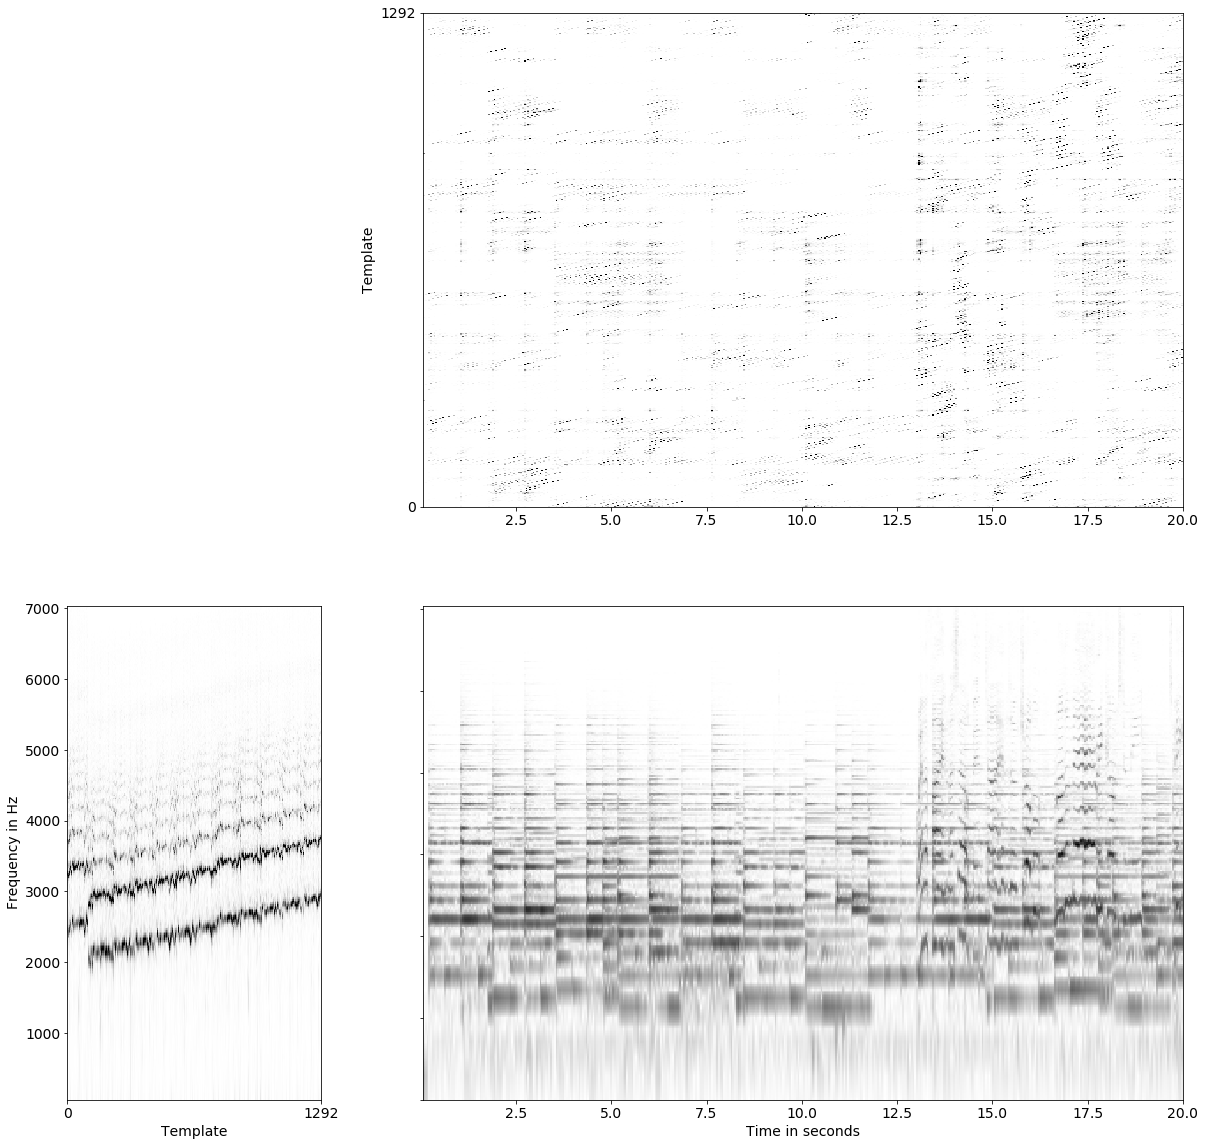

In [5]:
# visualize
paramVis = {}
paramVis['deltaF'] = deltaF
paramVis['deltaT'] = deltaT
paramVis['fontSize'] = 14

fh1, _ = visualizeComponentsNMF(At, nmfdiagW, nmfdiagH, None, paramVis)
fh1.savefig(os.path.join(outPath, 'LetItBee_NMFdiag.png'))

In [6]:
# resynthesize using Griffin-Lim, 50 iterations by default
_, _, res = LSEE_MSTFTM_GriffinLim(contY, paramSTFT)

# save result
wav.write(filename=os.path.join(outPath, 'LetItBee_NMFdiag_with_target_' + filenameTarget),
          rate=fs,
          data=res*MAX_WAV_VALUE)

#### Let it Be

In [7]:
# play
ipd.Audio(xt, rate=fs)

#### Buzzing Bees

In [8]:
# play
ipd.Audio(xs, rate=fs)

#### Let it Bee!

In [9]:
# play
ipd.Audio(res.T, rate=fs)